# Importamos librerias a usar

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

# Cargamos y dividimos nuestra data prepocesada

In [3]:
df= pd.read_csv('../data/process/data.csv')

In [4]:
X = df.drop(columns=['Fraud'])
y = df['Fraud']

In [5]:
train_ratio = 0.70
test_ratio = 0.15
validation_ratio = 0.15

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=42, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=validation_ratio/(train_ratio+test_ratio), random_state=42, stratify=y_train)

In [7]:
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(7000, 8)
(1500, 8)
(1500, 8)


# Construimos modelo MLP del tipo AutoEncoder

In [8]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim:int, hidden_dim:int):
        assert input_dim > 0, "Input dimension must be greater than 0"
        assert hidden_dim > 0, "Hidden dimension must be greater than 0"

        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

        self.out = nn.Sigmoid()

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.out(x)
        return x


In [9]:
features_names = ["Amount", "MCC_5261","MCC_5411","MCC_5812","MCC_5942","MCC_5968","MCC_7299", "TransactionSpeed"]

In [10]:
def train_ae_model(data: pd.DataFrame, num_epochs=100, batch_size=32, hidden_dim=64):
    features = data.loc[:, features_names]
    model = AutoEncoder(input_dim=len(features_names), hidden_dim=hidden_dim)

    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    
    dataset = torch.utils.data.TensorDataset(torch.tensor(features.values, dtype=torch.float32))
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(num_epochs):
        for batch in dataloader:
            optimizer.zero_grad()
            outputs = model(batch[0])
            loss = criterion(outputs, batch[0])
            loss.backward()
            optimizer.step()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
    return model

# Entrenamiento

In [11]:
normal_data = df[df['Fraud'] == 0]
ae_model = train_ae_model(normal_data)


Epoch [1/100], Loss: 0.1726
Epoch [2/100], Loss: 0.1116
Epoch [3/100], Loss: 0.2169
Epoch [4/100], Loss: 0.1129
Epoch [5/100], Loss: 0.2642
Epoch [6/100], Loss: 0.2596
Epoch [7/100], Loss: 0.0991
Epoch [8/100], Loss: 0.2000
Epoch [9/100], Loss: 0.1730
Epoch [10/100], Loss: 0.0889
Epoch [11/100], Loss: 0.0805
Epoch [12/100], Loss: 0.1626
Epoch [13/100], Loss: 0.0924
Epoch [14/100], Loss: 0.0839
Epoch [15/100], Loss: 0.0912
Epoch [16/100], Loss: 0.0951
Epoch [17/100], Loss: 0.1106
Epoch [18/100], Loss: 0.1519
Epoch [19/100], Loss: 0.1704
Epoch [20/100], Loss: 0.0962
Epoch [21/100], Loss: 0.1261
Epoch [22/100], Loss: 0.1025
Epoch [23/100], Loss: 0.1833
Epoch [24/100], Loss: 0.1412
Epoch [25/100], Loss: 0.1006
Epoch [26/100], Loss: 0.1064
Epoch [27/100], Loss: 0.1315
Epoch [28/100], Loss: 0.2086
Epoch [29/100], Loss: 0.1994
Epoch [30/100], Loss: 0.1579
Epoch [31/100], Loss: 0.1884
Epoch [32/100], Loss: 0.1518
Epoch [33/100], Loss: 0.1173
Epoch [34/100], Loss: 0.1835
Epoch [35/100], Loss: 0

In [12]:
print(ae_model)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=8, bias=True)
  )
  (out): Sigmoid()
)


# Evaluacion del modelo

In [13]:
def get_reconstruction_errors(model, data_tensor):
    model.eval()
    with torch.no_grad():
        reconstructed = model(data_tensor)
        errors = torch.mean((reconstructed - data_tensor) ** 2, dim=1)
    return errors.numpy()

In [14]:
def evaluate_results(y_true, y_pred, errors, dataset_name="Validación"):
    print(f"\n=== {dataset_name.upper()} ===")
    print(classification_report(y_true, y_pred, zero_division=0))
    print("ROC AUC :", roc_auc_score(y_true, errors))
    print("Matriz de Confusión:")
    print(confusion_matrix(y_true, y_pred))

In [15]:
X_train_tensor = torch.tensor(X_train[features_names].values, dtype=torch.float32)
X_valid_tensor = torch.tensor(X_valid[features_names].values, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test[features_names].values,  dtype=torch.float32)

errors_train = get_reconstruction_errors(ae_model, X_train_tensor)
errors_valid = get_reconstruction_errors(ae_model, X_valid_tensor)
errors_test  = get_reconstruction_errors(ae_model, X_test_tensor)

In [28]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, errors_train)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, errors_valid)
fpr_test,  tpr_test,  thresholds_test = roc_curve(y_test,  errors_test)

In [ ]:
optimal_idx_valid = (tpr_valid - fpr_valid).argmax()
optimal_idx_test = (tpr_test - fpr_test).argmax()

threshold_valid = thresholds_valid[optimal_idx_valid]
threshold_test = thresholds_test[optimal_idx_test]

In [ ]:
y_valid_pred = (errors_valid > threshold_valid).astype(int)
y_test_pred  = (errors_test > threshold_test).astype(int)

In [26]:
evaluate_results(y_valid, y_valid_pred, errors_valid, "VALIDACION")
evaluate_results(y_test,  y_test_pred,  errors_test,  "TEST")


=== VALIDACION ===
              precision    recall  f1-score   support

           0       1.00      0.78      0.87      1471
           1       0.08      0.97      0.15        29

    accuracy                           0.78      1500
   macro avg       0.54      0.87      0.51      1500
weighted avg       0.98      0.78      0.86      1500

ROC AUC : 0.942661572001219
Matriz de Confusión:
[[1142  329]
 [   1   28]]

=== TEST ===
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      1471
           1       0.19      0.79      0.30        29

    accuracy                           0.93      1500
   macro avg       0.59      0.86      0.63      1500
weighted avg       0.98      0.93      0.95      1500

ROC AUC : 0.931761175836283
Matriz de Confusión:
[[1370  101]
 [   6   23]]


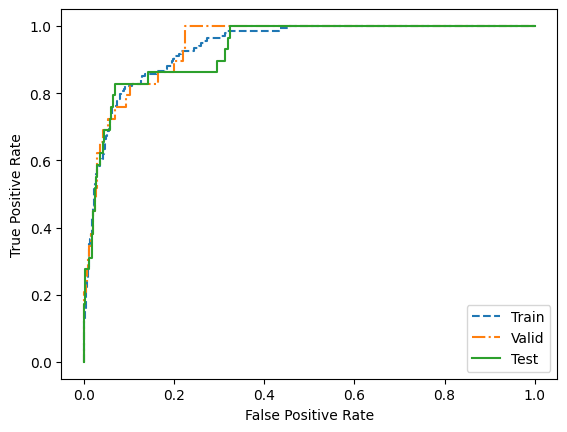

In [27]:
plt.plot(fpr_train, tpr_train, linestyle='--', label='Train')
plt.plot(fpr_valid, tpr_valid, linestyle='-.', label='Valid')
plt.plot(fpr_test,  tpr_test,  linestyle='-',  label='Test')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()